In [95]:
!python -V
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gpytorch as gp
from typing import Callable


rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

# Question 2

## (a)

Set $\sigma(R_1, R_2) = \beta_0 + \beta_1 R_1 + \beta_2 \sqrt{R_2}$. Then for the model

$$
\begin{align*}
    dS_t &= S_t \sigma(R_{1, t}, R_{2, t}) dW_t \\
    dR_{1, t} &= \lambda_1 \sigma(R_{1, t}, R_{2, t}) dW_t - \lambda_1 R_{1, t} dt \\
    dR_{2, t} &= \lambda_2 \left( \sigma(R_{1, t}, R_{2, t})^2 - R_{2, t} \right) dt
\end{align*}
$$

We will use the Euler-Maruyama discretization

$$
\begin{align*}
    \hat{S}_{n+1} &= \hat{S}_{n} + \hat{S}_{n} \sigma(\hat{R}_{1, n}, \hat{R}_{2, n}) \Delta W_n \\
    \hat{R}_{1, n+1} &= \hat{R}_{1, n} + \lambda_1 \sigma(\hat{R}_{1, n}, \hat{R}_{2, n}) \Delta W_n - \lambda_1 \hat{R}_{1, n} \Delta t \\
    \hat{R}_{2, n+1} &= \hat{R}_{2, n} + \lambda_2 \left( \sigma(\hat{R}_{1, n}, \hat{R}_{2, n})^2 - \hat{R}_{2, n} \right) \Delta t
\end{align*}
$$

In [96]:
def sigma(r1, r2, *, b0=0.08, b1=-0.08, b2=0.5):
    return b0 + b1 * r1 + b2 * np.sqrt(r2)

def generate_mc_samples(
    *,
    S0: float = 8.0,
    R10: float = -0.044,
    R20: float = 0.007,
    lambda1: float = 62,
    lambda2: float = 40,
    dt: float = 0.001,
    T: float = 0.33,
    M: int = 1000,
    dW: np.ndarray | None = None
) -> np.ndarray:
    path_length = int(T / dt) + 1 # 0, dt, ..., T

    S = np.empty((M, path_length))
    R1 = np.empty((M, path_length))
    R2 = np.empty((M, path_length))

    S[:, 0], R1[:, 0], R2[:, 0] = S0, R10, R20

    dW = dW if dW is not None else rng.normal(scale=np.sqrt(dt), size=(M, path_length-1))

    for i in range(path_length-1):
        Sn, R1n, R2n, dWn = S[:, i], R1[:, i], R2[:, i], dW[:, i]
        
        S[:, i+1] = Sn + Sn * sigma(R1n, R2n) * dWn
        R1[:, i+1] = R1n + lambda1 * sigma(R1n, R2n) * dWn - lambda1 * R1n * dt
        R2[:, i+1] = R2n + lambda2 * (sigma(R1n, R2n)**2 - R2n) * dt

    return S

In [97]:
def get_payoff(S0: float, *, M: int = 1000, dW: np.ndarray | None = None):
    simulation = generate_mc_samples(S0=S0, M=M, dW=dW)
    return np.average(np.maximum(simulation[:, -1] - 10, 0))

def get_delta(S0: float, *, eps: float = 5e-3, M: int = 1000) -> float:
    dW = rng.normal(scale=np.sqrt(0.001), size=(M, 330))

    top_payoff = get_payoff(S0 + eps, M=M, dW=dW)
    bottom_payoff = get_payoff(S0 - eps, M=M, dW=dW)

    return (top_payoff - bottom_payoff) / (2 * eps)

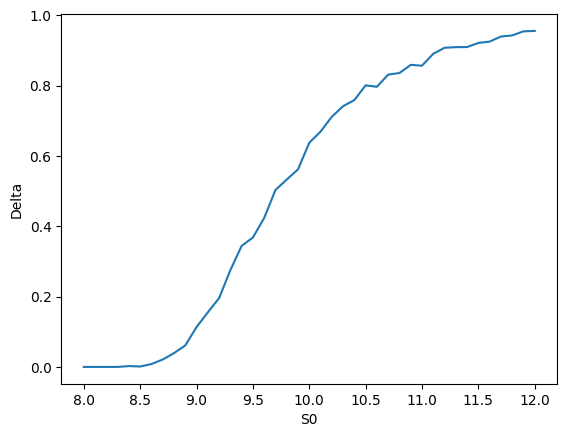

In [98]:
s_range = np.linspace(8, 12, int(4 / 0.1) + 1)

deltas = np.array([get_delta(s) for s in s_range])

ax = sns.lineplot(x=s_range, y=deltas)
ax.set_xlabel('S0')
ax.set_ylabel('Delta')

plt.show()

## (b)

In [99]:
data = torch.tensor(s_range, requires_grad=True)
target = torch.tensor([get_payoff(s) for s in s_range])

class GP(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cov_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, cov_x)

likelihood=gp.likelihoods.GaussianLikelihood()
gp_surrogate = GP(data, target, likelihood=likelihood)
# likelihood specifices the districution of y, i.e. p(y | x) ~ likelihood(x)

# code adapted from: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html

# Find optimal model hyperparameters
gp_surrogate.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp_surrogate.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, gp_surrogate)

for i in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_surrogate(data)
    # Calc loss and backprop gradients
    loss = -mll(output, target)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, 50, loss.item(),
        gp_surrogate.covar_module.base_kernel.lengthscale.item(),
        gp_surrogate.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.945   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.900   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.855   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.811   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.768   lengthscale: 0.911   noise: 0.513
Iter 6/50 - Loss: 0.725   lengthscale: 0.970   noise: 0.474
Iter 7/50 - Loss: 0.683   lengthscale: 1.030   noise: 0.437
Iter 8/50 - Loss: 0.643   lengthscale: 1.091   noise: 0.402
Iter 9/50 - Loss: 0.602   lengthscale: 1.152   noise: 0.370
Iter 10/50 - Loss: 0.563   lengthscale: 1.214   noise: 0.340
Iter 11/50 - Loss: 0.524   lengthscale: 1.276   noise: 0.312
Iter 12/50 - Loss: 0.485   lengthscale: 1.338   noise: 0.285
Iter 13/50 - Loss: 0.445   lengthscale: 1.399   noise: 0.261
Iter 14/50 - Loss: 0.404   lengthscale: 1.460   noise: 0.238
Iter 15/50 - Loss: 0.362   lengthscale: 1.520   noise: 0.217
Iter 16/50 - Loss: 0.319   lengthscale: 1.579   noise: 0.198
Iter 17/50 - Loss: 0.275   length

c:\Users\holyd_lrfudwy\AppData\Local\Programs\Python\Python313\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor([-16.3343,  -6.8288,   0.4281,   5.4674,   8.4979,   9.1399,   8.5102,
          6.9421,   3.0127,   0.3787,  -1.6829,  -4.2687,  -6.8667,   1.8835,
         -2.5811,  -1.5031,  -0.9430,  -1.4072,  -0.6273,   2.1755,   0.6108,
          1.3848,   2.2556,  -0.1993,  -1.7297,  -4.7910, -17.5376,  -2.2928,
        -14.5712,  19.7376,  34.8488,  10.8295,  30.5770, -10.4991,  -5.4527,
         -2.0503,   0.5698,   2.6466, -34.6340,   5.0120, -18.1076],
       dtype=torch.float64)

<Axes: >

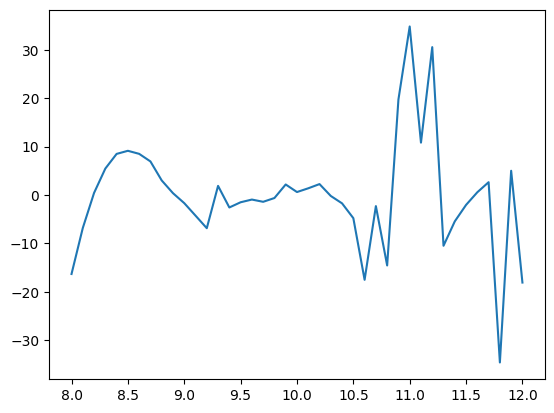

In [101]:
# evaluate gradient of model w.r.t input
gp_surrogate.eval()
likelihood.eval()
optimizer.zero_grad()

out = likelihood(gp_surrogate(data)).mean

delta = torch.autograd.grad(out, data, torch.ones_like(out))[0]

display(delta)

sns.lineplot(x=data.detach().numpy(), y=delta.detach().numpy())

# Question 3